# 📘 Empirical Finance: Question 1 - Return Predictability with Volatility Measures

In this section, we evaluate whether **volatility** can predict **future cumulative excess returns**.

### **Objectives:**
1. Compute **historical (realized) volatility** from daily excess returns
2. Estimate **conditional volatility** using GARCH(1,1)
3. Run predictive regressions for **1, 2, 3, and 4-year horizons**
   - Include **Newey-West standard errors**
   - Report **beta, t-statistics, R²** in formatted tables
4. Compare the predictive power of realized volatility vs GARCH volatility

----


## 📦  Step 1: Load Daily Data and Compute Realized Volatility (Historical Volatility)

In [1]:
# Load required packages
import pandas as pd
import numpy as np
from arch import arch_model
import statsmodels.api as sm

# 1. Load and preprocess data --------------------------------------------
daily_data = pd.read_csv("fama_french_data2.csv")
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data['year'] = daily_data['date'].dt.year
daily_data = daily_data[
    (daily_data['date'] >= '1963-07-01') & 
    (daily_data['date'] <= '2022-12-31') & 
    (~daily_data['mktrf'].isna())
]

# 2. Calculate Realized Volatility (vol) ---------------------------------
realized_vol = daily_data.groupby('year')['mktrf'].agg(
    vol=lambda x: x.std() * np.sqrt(252)  # Annualized historical volatility
).reset_index()

## 🔍 Step 2: Estimate Conditional Volatility Using GARCH(1,1)

In [2]:
# 3. Initialize merged_data ----------------------------------------------
merged_data = daily_data.groupby('year')['mktrf'].agg(
    annual_ret=lambda x: np.prod(1 + x) - 1
).reset_index()
merged_data = pd.merge(merged_data, realized_vol, on='year')

# Add columns for GARCH results
merged_data['cvol_garch'] = np.nan
merged_data['omega'] = np.nan
merged_data['alpha'] = np.nan
merged_data['beta'] = np.nan

# 4. GARCH(1,1) Estimation Year-by-Year -----------------------------------
for idx, row in merged_data.iterrows():
    current_year = row['year']
    subset = daily_data[daily_data['year'] <= current_year]

    if len(subset) < 50:
        continue

    try:
        # Rescale returns for stability
        model = arch_model(subset['mktrf'] * 100, vol='GARCH', p=1, q=1, mean='Zero')
        res = model.fit(disp='off')

        # Extract sigma and rescale back
        sigma = res.conditional_volatility[subset['year'] == current_year] / 100
        if not sigma.empty:
            annualized_vol = np.sqrt(np.mean(sigma**2)) * np.sqrt(252)
            merged_data.loc[idx, 'cvol_garch'] = annualized_vol

        # Extract GARCH parameters
        params = res.params
        merged_data.loc[idx, 'omega'] = params.get('omega', np.nan)
        merged_data.loc[idx, 'alpha'] = params.get('alpha[1]', np.nan)
        merged_data.loc[idx, 'beta'] = params.get('beta[1]', np.nan)

    except Exception as e:
        print(f"GARCH failed for {current_year}: {e}")
        continue
    
# 5. Print Average Volatilities ------------------------------------------
print("\n--- Average Annualized Volatility ---")
print("Realized Volatility:", round(merged_data['vol'].mean() * 100, 2), "%")
print("GARCH Conditional Volatility:", round(merged_data['cvol_garch'].mean() * 100, 2), "%")


--- Average Annualized Volatility ---
Realized Volatility: 14.74 %
GARCH Conditional Volatility: 14.92 %


In [3]:
from tabulate import tabulate

# Fit GARCH model on full dataset for final parameter estimation
final_model = arch_model(daily_data['mktrf'] * 100, vol='GARCH', p=1, q=1, mean='Zero')
final_res = final_model.fit(disp='off')

# Extract parameters, std errors, t-stats, p-values
params = final_res.params
std_err = final_res.std_err
t_stats = final_res.tvalues
p_vals = final_res.pvalues

# Organize into a list of rows
table_data = [
    ['Omega (ω)', f"{params['omega']:.3f}{'***' if p_vals['omega'] < 0.01 else '**' if p_vals['omega'] < 0.05 else '*' if p_vals['omega'] < 0.1 else ''}",
     f"{std_err['omega']:.3f}", f"{t_stats['omega']:.3f}", f"{p_vals['omega']:.3f}"],

    ['Alpha (α)', f"{params['alpha[1]']:.3f}{'***' if p_vals['alpha[1]'] < 0.01 else '**' if p_vals['alpha[1]'] < 0.05 else '*' if p_vals['alpha[1]'] < 0.1 else ''}",
     f"{std_err['alpha[1]']:.3f}", f"{t_stats['alpha[1]']:.3f}", f"{p_vals['alpha[1]']:.3f}"],

    ['Beta (β)', f"{params['beta[1]']:.3f}{'***' if p_vals['beta[1]'] < 0.01 else '**' if p_vals['beta[1]'] < 0.05 else '*' if p_vals['beta[1]'] < 0.1 else ''}",
     f"{std_err['beta[1]']:.3f}", f"{t_stats['beta[1]']:.3f}", f"{p_vals['beta[1]']:.3f}"]
]

# Print the table
print("\nTable: GARCH Coefficient Estimates\n")
print(tabulate(table_data, headers=['Coefficient', 'Estimate', 'Std. Error', 't-Statistic', 'p-Value'], tablefmt='grid'))

# Print significance note
print("\nNote: *p < 0.1, **p < 0.05, ***p < 0.01")



Table: GARCH Coefficient Estimates

+---------------+------------+--------------+---------------+-----------+
| Coefficient   | Estimate   |   Std. Error |   t-Statistic |   p-Value |
+===============+============+==============+===============+===========+
| Omega (ω)     | 0.010***   |        0.002 |         4.754 |         0 |
+---------------+------------+--------------+---------------+-----------+
| Alpha (α)     | 0.096***   |        0.011 |         8.948 |         0 |
+---------------+------------+--------------+---------------+-----------+
| Beta (β)      | 0.896***   |        0.011 |        82.636 |         0 |
+---------------+------------+--------------+---------------+-----------+

Note: *p < 0.1, **p < 0.05, ***p < 0.01


## 🧭 Step 3: Predict Future Returns Using Volatility Measures

Now we examine the predictive power of the two volatility measures — historical and GARCH-based — for future cumulative market excess returns.

In [4]:
# 6. Compute future cumulative returns -----------------------------------
for h in range(1, 5):
    merged_data[f'cumret_{h}y'] = 1.0
    for i in range(1, h + 1):
        merged_data[f'cumret_{h}y'] *= (1 + merged_data['annual_ret'].shift(-i))
    merged_data[f'cumret_{h}y'] -= 1.0

# 7. Predictive Regressions (Newey-West HAC) ------------------------------
def run_regression(predictor, horizon, data):
    y = data[f'cumret_{horizon}y'].dropna()
    X = data[predictor].loc[y.index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    nw_model = model.get_robustcov_results(cov_type='HAC', maxlags=horizon - 1)
    return nw_model

# 8. Create Results Table -------------------------------------------------
results = []
filtered_data = merged_data.dropna(subset=['vol', 'cvol_garch', 'cumret_1y', 'cumret_2y', 'cumret_3y', 'cumret_4y'])

for h in range(1, 5):
    # Realized Vol
    realized_model = run_regression('vol', h, filtered_data)
    results.append({
        'Horizon': h,
        'Predictor': 'Realized Vol',
        'Beta': round(realized_model.params[1], 3),
        'T_stat': round(realized_model.tvalues[1], 3),
        'R2': round(realized_model.rsquared, 3)
    })

    # GARCH Vol
    garch_model = run_regression('cvol_garch', h, filtered_data)
    results.append({
        'Horizon': h,
        'Predictor': 'GARCH Vol',
        'Beta': round(garch_model.params[1], 3),
        'T_stat': round(garch_model.tvalues[1], 3),
        'R2': round(garch_model.rsquared, 3)
    })

# 9. Display Final Table --------------------------------------------------
results_df = pd.DataFrame(results)
print("\n--- Predictive Regression Results ---")
print(results_df.to_string(index=False))


--- Predictive Regression Results ---
 Horizon    Predictor  Beta  T_stat    R2
       1 Realized Vol 0.503   1.762 0.036
       1    GARCH Vol 0.552   1.854 0.039
       2 Realized Vol 1.033   2.006 0.069
       2    GARCH Vol 1.079   2.026 0.069
       3 Realized Vol 0.711   1.017 0.022
       3    GARCH Vol 0.801   1.115 0.026
       4 Realized Vol 0.929   0.881 0.026
       4    GARCH Vol 1.147   1.073 0.036


## 📊 Step 4: Visualize Annualized Volatilities

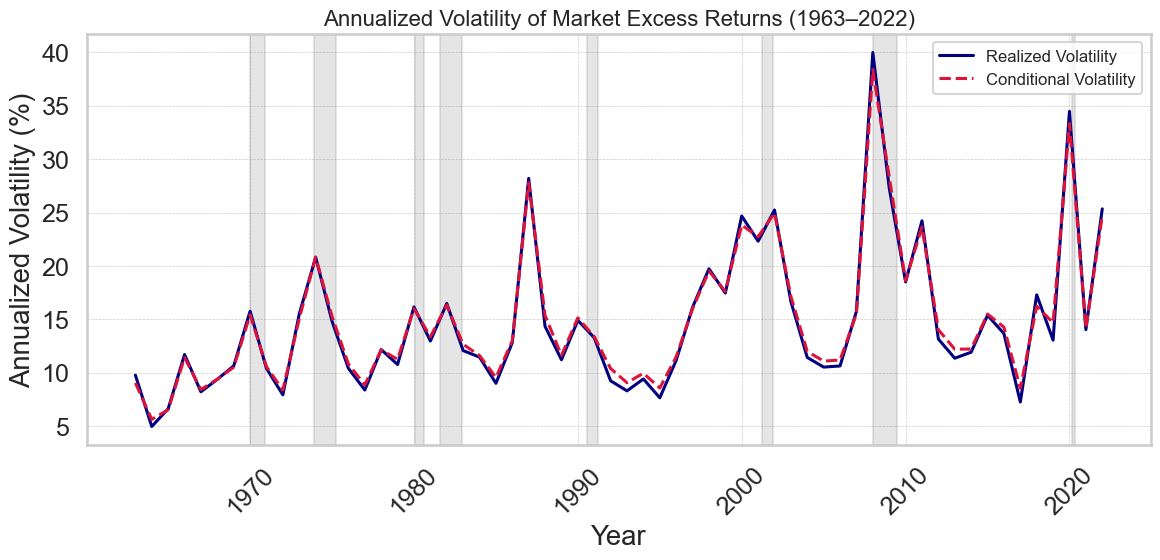

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas_datareader.data as web

# Step 1: Create vol_data from merged_data and rename columns
vol_data = merged_data.copy()
vol_data.rename(columns={
    'vol': 'Realized Volatility',
    'cvol_garch': 'GARCH(1,1) Volatility'
}, inplace=True)

# Create a datetime index from 'year'
vol_data['year_dt'] = pd.to_datetime(vol_data['year'], format='%Y')
vol_data.set_index('year_dt', inplace=True)

# Convert volatility values to percentage scale
vol_data['Realized Volatility'] = vol_data['Realized Volatility'] * 100
vol_data['GARCH(1,1) Volatility'] = vol_data['GARCH(1,1) Volatility'] * 100

# Step 2: Download and prepare US Recession data
recessions = web.DataReader('USREC', 'fred', start='1963', end='2023')
recessions['shift'] = recessions['USREC'].shift(1)
recession_spans = []
recession_start = None

for date, row in recessions.iterrows():
    if row['USREC'] == 1 and (row['shift'] == 0 or pd.isna(row['shift'])):
        recession_start = date
    elif row['USREC'] == 0 and row['shift'] == 1:
        if recession_start:
            recession_spans.append((recession_start, date))
            recession_start = None

# Step 3: Plot the volatility series
sns.set(style="whitegrid", context="talk", font_scale=1.1)

plt.figure(figsize=(12, 6))
plt.plot(vol_data.index, vol_data['Realized Volatility'],
         label='Realized Volatility', color='navy', linewidth=2.2)
plt.plot(vol_data.index, vol_data['GARCH(1,1) Volatility'],
         label='Conditional Volatility', color='crimson', linestyle='--', linewidth=2.2)

# Add recession shading
for start, end in recession_spans:
    plt.axvspan(start, end, color='grey', alpha=0.2)

# Formatting and labels
plt.title('Annualized Volatility of Market Excess Returns (1963–2022)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Annualized Volatility (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Final touches
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Save the figure
plt.savefig("volatility_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# 📘 Q2: Macroeconomic Impact of Volatility and Credit Spreads

This section investigates whether historical volatility and credit spreads can predict future GDP growth. The analysis uses quarterly macroeconomic data from 1963 to 2022 and includes:

- **Augmented Dickey-Fuller (ADF)** tests to check stationarity of log-level variables
- Residual-based **cointegration tests** across consumption, investment, and GDP
- Construction of forward-looking GDP growth rates across different horizons (1q to 4y)
- **Predictive regressions** for different horizons

---

## 📌  Step 1: Load and Prepare the Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from IPython.display import display, Markdown
import warnings

warnings.filterwarnings("ignore")

df = pd.read_stata("dataq2.dta")
df['qdate'] = pd.to_datetime(df['qdate'])
df.set_index('qdate', inplace=True)
df.head()

,lnpce,lnpnfi,lngdp,volatility,credspread
qdate,,,,,
1963-01-01,3.418055,4.602056,2.841065,NaN,0.0069
1963-04-01,3.421327,4.621536,2.842814,NaN,0.0061
1963-07-01,3.424914,4.650258,2.844153,0.409504,0.0053
1963-10-01,3.430109,4.674593,2.852208,0.776647,0.0050
1964-01-01,3.432050,4.704780,2.855378,0.214777,0.0045


## 🔗  Step 2: Stationarity Tests (ADF) 

In [7]:
def run_adf(series, name, lags=None):
    result = adfuller(series.dropna(), maxlag=lags, regression='ct', autolag=None if lags else 'AIC')
    print(f"ADF Test on {name}, lags={lags}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print("  Critical Values:", result[4])
    print("  Conclusion:", "Stationary" if result[1] < 0.05 else "Non-stationary", "\n")

for col in ['lnpce', 'lnpnfi', 'lngdp']:
    for lags in [None, 1, 2]:
        run_adf(df[col], col, lags)

ADF Test on lnpce, lags=None:
  Test Statistic: -1.3092
  p-value: 0.8856
  Critical Values: {'1%': -3.997651213253911, '5%': -3.4292590796953437, '10%': -3.1380781066954264}
  Conclusion: Non-stationary 

ADF Test on lnpce, lags=1:
  Test Statistic: -0.5332
  p-value: 0.9821
  Critical Values: {'1%': -3.9973200578432064, '5%': -3.4290999471622556, '10%': -3.1379848180498104}
  Conclusion: Non-stationary 

ADF Test on lnpce, lags=2:
  Test Statistic: -0.8532
  p-value: 0.9609
  Critical Values: {'1%': -3.9974849273594386, '5%': -3.4291791746599865, '10%': -3.1380312642272385}
  Conclusion: Non-stationary 

ADF Test on lnpnfi, lags=None:
  Test Statistic: -1.8425
  p-value: 0.6839
  Critical Values: {'1%': -3.9973200578432064, '5%': -3.4290999471622556, '10%': -3.1379848180498104}
  Conclusion: Non-stationary 

ADF Test on lnpnfi, lags=1:
  Test Statistic: -1.8425
  p-value: 0.6839
  Critical Values: {'1%': -3.9973200578432064, '5%': -3.4290999471622556, '10%': -3.1379848180498104}
  Co

### 🎯 Plot: Natural Logarithm of Consumption (lnpce)

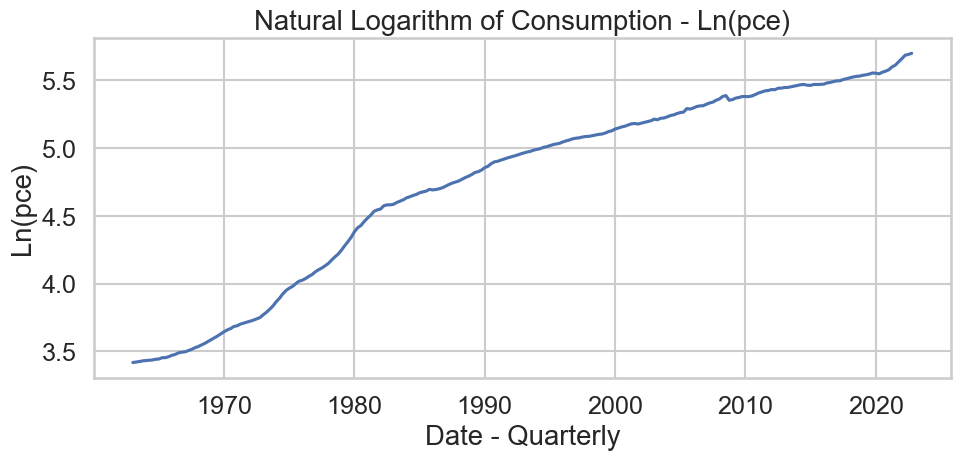

In [8]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='lnpce')
plt.title("Natural Logarithm of Consumption - Ln(pce)")
plt.xlabel("Date - Quarterly")
plt.ylabel("Ln(pce)")
plt.grid(True)
plt.tight_layout()
plt.show()

### 🎯 Plot: Quarterly Volatility

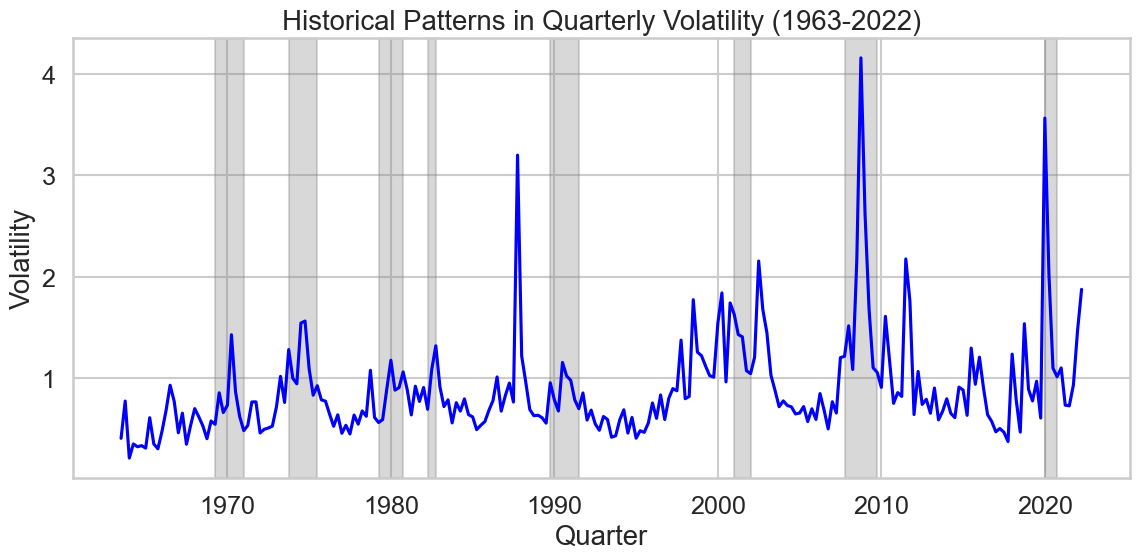

In [9]:
# Plot: Quarterly Volatility with Shaded Recession Periods
recession_ranges = [
    ("1969-04-01", "1971-01-01"), ("1973-10-01", "1975-07-01"),
    ("1979-04-01", "1980-10-01"), ("1982-04-01", "1982-10-01"),
    ("1989-10-01", "1991-07-01"), ("2001-01-01", "2002-01-01"),
    ("2007-10-01", "2009-10-01"), ("2020-01-01", "2020-10-01")
]

plt.figure(figsize=(12, 6))
for start, end in recession_ranges:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='grey', alpha=0.3)
sns.lineplot(x=df.index, y='volatility', data=df, color='blue')
plt.title("Historical Patterns in Quarterly Volatility (1963-2022)")
plt.xlabel("Quarter")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

## 🔍  Step 3: Cointegration Tests using Residual-Based ADF

In [10]:
def manual_cointegration(x, y, name1, name2, lag=1):
    model = sm.OLS(y.dropna(), sm.add_constant(x.dropna())).fit()
    resid = model.resid
    result = adfuller(resid, maxlag=lag)
    print(f"Cointegration Test: {name1} vs. {name2}")
    print(f"  Test Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    print("  Conclusion:", "Cointegrated" if result[1] < 0.05 else "Not Cointegrated", "\n")

manual_cointegration(df['lngdp'], df['lnpce'], "lngdp", "lnpce", lag=1)
manual_cointegration(df['lnpce'], df['lnpnfi'], "lnpce", "lnpnfi", lag=3)
manual_cointegration(df['lngdp'], df['lnpnfi'], "lngdp", "lnpnfi", lag=2)

Cointegration Test: lngdp vs. lnpce
  Test Statistic: -2.2190, p-value: 0.1994
  Conclusion: Not Cointegrated 

Cointegration Test: lnpce vs. lnpnfi
  Test Statistic: -3.4353, p-value: 0.0098
  Conclusion: Cointegrated 

Cointegration Test: lngdp vs. lnpnfi
  Test Statistic: -3.0843, p-value: 0.0277
  Conclusion: Cointegrated 



## 📂  Step 4: Growth Rates and Predictive Regressions

In [11]:
df['fdlnpce'] = df['lnpce'].diff()
df['fdlnpnfi'] = df['lnpnfi'].diff()
df['fdlngdp'] = df['lngdp'].diff()

for col in ['fdlnpce', 'fdlnpnfi', 'fdlngdp']:
    run_adf(df[col], col)

ADF Test on fdlnpce, lags=None:
  Test Statistic: -4.0671
  p-value: 0.0070
  Critical Values: {'1%': -3.997651213253911, '5%': -3.4292590796953437, '10%': -3.1380781066954264}
  Conclusion: Stationary 

ADF Test on fdlnpnfi, lags=None:
  Test Statistic: -13.3569
  p-value: 0.0000
  Critical Values: {'1%': -3.9973200578432064, '5%': -3.4290999471622556, '10%': -3.1379848180498104}
  Conclusion: Stationary 

ADF Test on fdlngdp, lags=None:
  Test Statistic: -2.9974
  p-value: 0.1328
  Critical Values: {'1%': -3.998679721788444, '5%': -3.429753237774307, '10%': -3.1383677751294488}
  Conclusion: Non-stationary 



In [12]:
horizons = {'1q': 1, '2q': 2, '1y': 4, '2y': 8, '4y': 16}
for h, step in horizons.items():
    df[f'gdpgrowth_{h}'] = df['fdlngdp'].shift(-step)
    df[f'pcegrowth_{h}'] = df['fdlnpce'].shift(-step)
    df[f'pnfigrowth_{h}'] = df['fdlnpnfi'].shift(-step)
    df[f'volatility_{h}'] = df['volatility'].shift(-step)
    df[f'credspread_{h}'] = df['credspread'].shift(-step)
    
def predictive_reg(y_var, x_vars, label):
    df_model = df[[y_var] + x_vars].dropna()
    X = sm.add_constant(df_model[x_vars])
    y = df_model[y_var]
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

for h in horizons:
    predictive_reg(f'gdpgrowth_{h}', [f'credspread_{h}', f'pnfigrowth_{h}', f'pcegrowth_{h}'], f"creditspread_h={h}")
    predictive_reg(f'gdpgrowth_{h}', [f'volatility_{h}', f'pnfigrowth_{h}', f'pcegrowth_{h}'], f"volatility_h={h}")
    
def add_stars(coef, t):
    if abs(t) >= 2.58:
        return f"{coef:.3f}***"
    elif abs(t) >= 1.96:
        return f"{coef:.3f}**"
    elif abs(t) >= 1.65:
        return f"{coef:.3f}*"
    else:
        return f"{coef:.3f}"

def run_model_table_fixed(predictor):
    all_coefs = []
    all_ses = []
    for label, h in horizons.items():
        y = df[f'gdpgrowth_{label}']
        X = df[[f'{predictor}_{label}', f'pnfigrowth_{label}', f'pcegrowth_{label}']]
        data = pd.concat([y, X], axis=1).dropna()
        y_clean = data.iloc[:, 0]
        X_clean = sm.add_constant(data.iloc[:, 1:])
        model = sm.OLS(y_clean, X_clean).fit(cov_type='HAC', cov_kwds={'maxlags': 4})

        coefs = []
        ses = []
        for var in ['const', f'{predictor}_{label}', f'pnfigrowth_{label}', f'pcegrowth_{label}']:
            coef = model.params.get(var, np.nan)
            tval = model.tvalues.get(var, np.nan)
            stderr = model.bse.get(var, np.nan)
            coefs.append(add_stars(coef, tval))
            ses.append(f"({stderr:.3f})")
        all_coefs.append(coefs)
        all_ses.append(ses)

    rows = ['Constant', predictor.upper(), 'PNFI', 'PCE']
    cols = list(horizons.keys())
    coef_df = pd.DataFrame(np.array(all_coefs).T, index=rows, columns=cols)
    se_df = pd.DataFrame(np.array(all_ses).T, index=rows, columns=cols)

    final_df = pd.DataFrame(index=pd.MultiIndex.from_product([rows, ['β', '(se)']]), columns=cols)
    for row in rows:
        final_df.loc[(row, 'β')] = coef_df.loc[row]
        final_df.loc[(row, '(se)')] = se_df.loc[row]
    return final_df

panel_a_fixed = run_model_table_fixed('credspread')
panel_b_fixed = run_model_table_fixed('volatility')

display(Markdown("### Panel A: Credit Spread as Predictor"))
display(panel_a_fixed)

display(Markdown("### Panel B: Volatility as Predictor"))
display(panel_b_fixed)

### Panel A: Credit Spread as Predictor

1q        2q        1y        2y        4y
Constant   β       -0.000    -0.000    -0.000    -0.000    -0.000
           (se)   (0.001)   (0.001)   (0.001)   (0.001)   (0.001)
CREDSPREAD β     0.298***  0.296***  0.297***  0.300***  0.314***
           (se)   (0.067)   (0.068)   (0.068)   (0.069)   (0.070)
PNFI       β        0.013     0.013     0.013     0.013     0.013
           (se)   (0.009)   (0.009)   (0.009)   (0.009)   (0.009)
PCE        β     0.555***  0.554***  0.554***  0.555***  0.559***
           (se)   (0.061)   (0.061)   (0.061)   (0.061)   (0.062)

### Panel B: Volatility as Predictor

1q        2q        1y        2y        4y
Constant   β     0.002***  0.002***  0.002***  0.002***  0.002***
           (se)   (0.001)   (0.001)   (0.001)   (0.001)   (0.001)
VOLATILITY β        0.001     0.001     0.001     0.001     0.001
           (se)   (0.001)   (0.001)   (0.001)   (0.001)   (0.001)
PNFI       β        0.007     0.007     0.007     0.007     0.007
           (se)   (0.009)   (0.009)   (0.009)   (0.009)   (0.009)
PCE        β     0.573***  0.573***  0.572***  0.570***  0.572***
           (se)   (0.066)   (0.066)   (0.066)   (0.067)   (0.068)

# 📘 Q3: A performance comparison of four mutual funds

This section provides:
- A performance comparison of four mutual funds using **Sharpe ratios**
- A factor-based performance attribution using the **Fama-French 5-Factor Model**
- Statistical inference with **HAC (Newey-West) standard errors**

---


In [13]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import statsmodels.stats.diagnostic as smd

# Load the data
funds_df = pd.read_excel("Funds return M 2010-2024.xlsx")
ff_factors = pd.read_excel("FF-5Factors M 2010-2024.xlsx")

# Rename columns for clarity
funds_df.columns = ["Fund Name", "Date", "Fund Return"]
ff_factors.columns = ["Date", "MKT-RF", "SMB", "HML", "RMW", "CMA", "RF"]

# Convert Date columns to datetime format
funds_df["Date"] = pd.to_datetime(funds_df["Date"])
ff_factors["Date"] = pd.to_datetime(ff_factors["Date"])

# Convert Fama-French factors from percentages to decimals
ff_factors[["MKT-RF", "SMB", "HML", "RMW", "CMA", "RF"]] /= 100

# Merge data on Date
merged_df = pd.merge(funds_df, ff_factors[["Date", "RF"]], on="Date", how="inner")

# Calculate excess return
merged_df["Excess Return"] = merged_df["Fund Return"] - merged_df["RF"]


## 📦 Sharpe Ratio Table

In [14]:
# Compute Sharpe Ratio for each fund
sharpe_ratios = merged_df.groupby("Fund Name")["Excess Return"].agg(
    Mean_Excess_Return="mean",
    Std_Excess_Return="std"
)
sharpe_ratios["Sharpe Ratio"] = sharpe_ratios["Mean_Excess_Return"] / sharpe_ratios["Std_Excess_Return"]
sharpe_ratios = sharpe_ratios.round(3).reset_index()
sharpe_ratios


,Fund Name,Mean_Excess_Return,Std_Excess_Return,Sharpe Ratio
0,FDEGX,0.010,0.050,0.202
1,FFIDX,0.011,0.043,0.245
2,PRDSX,0.010,0.052,0.200
3,VISGX,0.010,0.056,0.174


## 📈 Fama-French 5-Factor Regression

In [15]:
# Merge with full factor dataset
final_df = pd.merge(merged_df, ff_factors, on="Date", how="inner")

results_list = []

# Run regression for each fund
for fund in final_df["Fund Name"].unique():
    fund_data = final_df[final_df["Fund Name"] == fund]
    y = fund_data["Excess Return"]
    X = fund_data[["MKT-RF", "SMB", "HML", "RMW", "CMA"]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    # HAC standard errors
    maxlags = int(4*(len(y)/100)**(2/9))
    hac_se = model.get_robustcov_results(cov_type='HAC', maxlags=maxlags)

    alpha = model.params["const"]
    betas = model.params[["MKT-RF", "SMB", "HML", "RMW", "CMA"]]
    r_squared = model.rsquared
    hac_std_errors = hac_se.bse
    hac_t_stats = hac_se.tvalues
    hac_p_values = hac_se.pvalues

    results_list.append([
        fund, alpha, *betas, r_squared,
        hac_std_errors[0], *hac_std_errors[1:],
        hac_t_stats[0], *hac_t_stats[1:],
        hac_p_values[0], *hac_p_values[1:]
    ])

columns = ["Fund", "Alpha", "Beta_MKT-RF", "Beta_SMB", "Beta_HML", "Beta_RMW", "Beta_CMA", "R-Squared",
           "SE_Alpha", "SE_MKT-RF", "SE_SMB", "SE_HML", "SE_RMW", "SE_CMA",
           "T_Alpha", "T_MKT-RF", "T_SMB", "T_HML", "T_RMW", "T_CMA",
           "P_Alpha", "P_MKT-RF", "P_SMB", "P_HML", "P_RMW", "P_CMA"]

results_df = pd.DataFrame(results_list, columns=columns)

def significance_label(t_value):
    if abs(t_value) >= 2.576:
        return "***"
    elif abs(t_value) >= 1.960:
        return "**"
    elif abs(t_value) >= 1.645:
        return "*"
    else:
        return ""

print(results_df)

    Fund     Alpha  Beta_MKT-RF  Beta_SMB  Beta_HML  Beta_RMW  Beta_CMA  \
0  FFIDX -0.000513     0.999663 -0.182313 -0.112466  0.013497 -0.061491   
1  FDEGX -0.000794     1.035149  0.127895 -0.132249 -0.116355 -0.157259   
2  PRDSX  0.000027     1.001643  0.510776 -0.099735 -0.052769 -0.097147   
3  VISGX -0.000669     1.042219  0.598917 -0.184255 -0.250297 -0.087001   

   R-Squared  SE_Alpha  SE_MKT-RF  ...      T_SMB     T_HML     T_RMW  \
0   0.965310  0.000663   0.016681  ...  -6.252603 -3.914644  0.258598   
1   0.902006  0.001105   0.035660  ...   2.244130 -2.467399 -1.367846   
2   0.944864  0.000888   0.027008  ...  10.964567 -2.271439 -0.949606   
3   0.966830  0.000694   0.023156  ...  15.985540 -5.395847 -4.845187   

      T_CMA   P_Alpha       P_MKT-RF         P_SMB         P_HML     P_RMW  \
0 -1.599312  0.439704  4.184032e-118  3.025536e-09  1.297823e-04  0.796251   
1 -1.895955  0.473742   1.332526e-68  2.608461e-02  1.457731e-02  0.173124   
2 -1.172402  0.975333   

## 🧮 Regression Summary Table

In [16]:
# Correct significance stars logic
def significance_label(t_value):
    if abs(t_value) >= 2.576:
        return "***"
    elif abs(t_value) >= 1.960:
        return "**"
    elif abs(t_value) >= 1.645:
        return "*"
    else:
        return ""

# Create formatted block for each fund and parameter
param_labels = [
    "Alpha", "Beta_MKT-RF", "Beta_SMB", "Beta_HML", "Beta_RMW", "Beta_CMA"
]

formatted = {}
for fund in results_df["Fund"].unique():
    fund_data = results_df[results_df["Fund"] == fund].iloc[0]
    col = []
    for param in param_labels:
        coef = fund_data[param]
        se = fund_data["SE_" + param.split("_")[1]] if "_" in param else fund_data["SE_Alpha"]
        t_stat = fund_data["T_" + param.split("_")[1]] if "_" in param else fund_data["T_Alpha"]
        p_val = fund_data["P_" + param.split("_")[1]] if "_" in param else fund_data["P_Alpha"]
        star = significance_label(t_stat)

        # Format with spacing
        coef_str = f"{coef:.3f}{star}"
        se_str = f"(SE: {se:.3f})"
        t_str = f"t = {t_stat:.3f},  p = {p_val:.3f}"
        
        block = f"{coef_str}\n{se_str}\n{t_str}"
        col.append(block)
    formatted[fund] = col

# Build DataFrame
formatted_df = pd.DataFrame(formatted, index=param_labels)
formatted_df.index.name = "Parameter"

# Apply styling for better spacing and readability
styled = formatted_df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-line',
    'line-height': '1.6',
    'font-family': 'monospace',
    'padding': '8px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

# Display table and note
display(styled)
print("\nNote: *** p < 0.01, ** p < 0.05, * p < 0.10")


,FFIDX,FDEGX,PRDSX,VISGX
Parameter,,,,
Alpha,"-0.001 (SE: 0.001) t = -0.774, p = 0.440","-0.001 (SE: 0.001) t = -0.718, p = 0.474","0.000 (SE: 0.001) t = 0.031, p = 0.975","-0.001 (SE: 0.001) t = -0.964, p = 0.336"
Beta_MKT-RF,"1.000*** (SE: 0.017) t = 59.930, p = 0.000","1.035*** (SE: 0.036) t = 29.029, p = 0.000","1.002*** (SE: 0.027) t = 37.086, p = 0.000","1.042*** (SE: 0.023) t = 45.008, p = 0.000"
Beta_SMB,"-0.182*** (SE: 0.029) t = -6.253, p = 0.000","0.128** (SE: 0.057) t = 2.244, p = 0.026","0.511*** (SE: 0.047) t = 10.965, p = 0.000","0.599*** (SE: 0.037) t = 15.986, p = 0.000"
Beta_HML,"-0.112*** (SE: 0.029) t = -3.915, p = 0.000","-0.132** (SE: 0.054) t = -2.467, p = 0.015","-0.100** (SE: 0.044) t = -2.271, p = 0.024","-0.184*** (SE: 0.034) t = -5.396, p = 0.000"
Beta_RMW,"0.013 (SE: 0.052) t = 0.259, p = 0.796","-0.116 (SE: 0.085) t = -1.368, p = 0.173","-0.053 (SE: 0.056) t = -0.950, p = 0.344","-0.250*** (SE: 0.052) t = -4.845, p = 0.000"
Beta_CMA,"-0.061 (SE: 0.038) t = -1.599, p = 0.112","-0.157* (SE: 0.083) t = -1.896, p = 0.060","-0.097 (SE: 0.083) t = -1.172, p = 0.243","-0.087 (SE: 0.063) t = -1.388, p = 0.167"



Note: *** p < 0.01, ** p < 0.05, * p < 0.10


## 📋 Plot: Evaluating Fund Performance: Model Fit vs Alpha

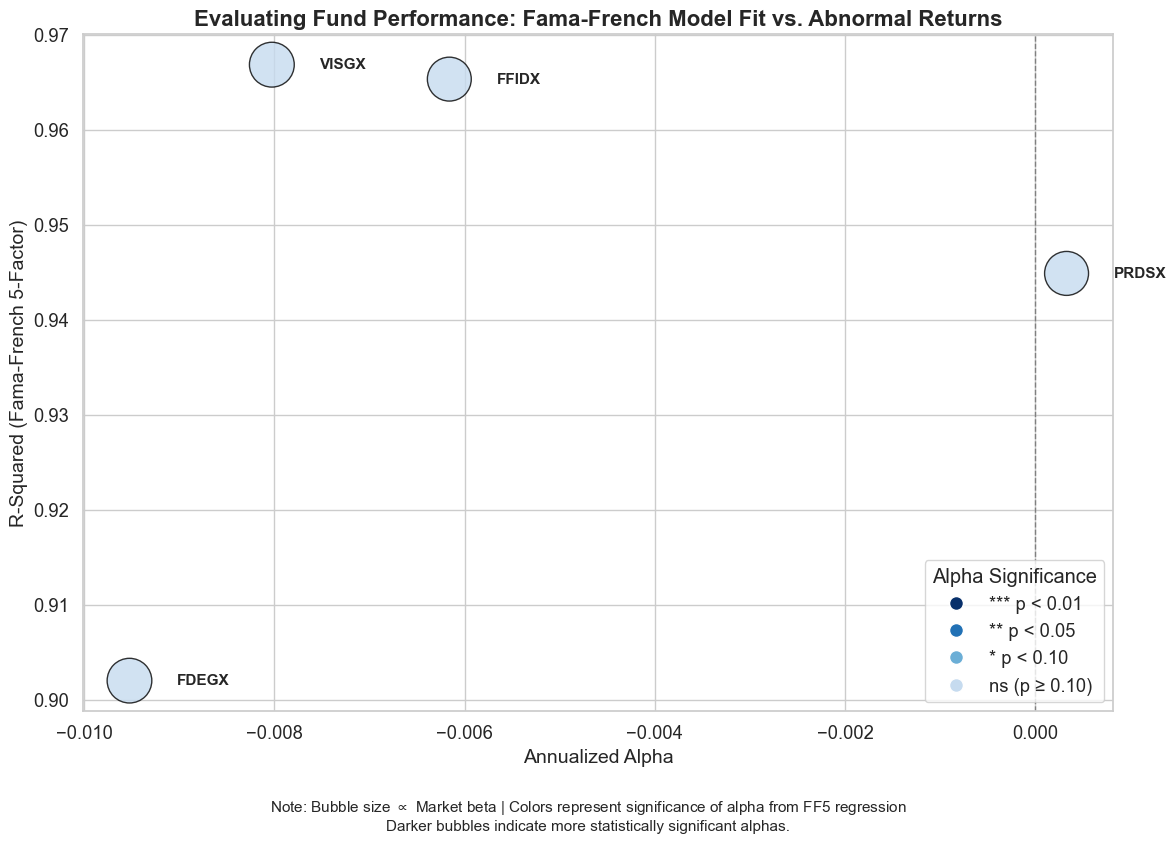

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
bubble_df = results_df[["Fund", "Alpha", "SE_Alpha", "R-Squared", "Beta_MKT-RF"]].copy()
bubble_df["Alpha_Annual"] = bubble_df["Alpha"] * 12
bubble_df["SE_Alpha_Annual"] = bubble_df["SE_Alpha"] * 12
bubble_df["T_Stat"] = bubble_df["Alpha_Annual"] / bubble_df["SE_Alpha_Annual"]

# Define color based on significance
def get_color(t):
    if abs(t) >= 2.576:
        return "#08306b"  # dark blue
    elif abs(t) >= 1.960:
        return "#2171b5"  # medium blue
    elif abs(t) >= 1.645:
        return "#6baed6"  # light blue
    else:
        return "#c6dbef"  # very light blue

bubble_df["Color"] = bubble_df["T_Stat"].apply(get_color)
bubble_df["Size"] = bubble_df["Beta_MKT-RF"].abs() * 1000  # scale bubble size

# Plot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid", font_scale=1.2)

scatter = plt.scatter(
    x=bubble_df["Alpha_Annual"],
    y=bubble_df["R-Squared"],
    s=bubble_df["Size"],
    c=bubble_df["Color"],
    edgecolors="black",
    alpha=0.8
)

# Add fund name annotations
for i in range(bubble_df.shape[0]):
    plt.text(bubble_df["Alpha_Annual"][i] + 0.0005, 
             bubble_df["R-Squared"][i], 
             bubble_df["Fund"][i],
             fontsize=11,
             fontweight='bold',
             ha='left', va='center')

# Axes and labels
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.xlabel("Annualized Alpha", fontsize=14)
plt.ylabel("R-Squared (Fama-French 5-Factor)", fontsize=14)
plt.title("Evaluating Fund Performance: Fama-French Model Fit vs. Abnormal Returns", fontsize=16, weight='bold')

# Custom legend for color significance
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='*** p < 0.01', markerfacecolor='#08306b', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='** p < 0.05', markerfacecolor='#2171b5', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='* p < 0.10', markerfacecolor='#6baed6', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='ns (p ≥ 0.10)', markerfacecolor='#c6dbef', markersize=10),
]
plt.legend(handles=legend_elements, title="Alpha Significance", loc="lower right")

# Caption
plt.figtext(0.5, -0.05,
            "Note: Bubble size $\propto$ Market beta | Colors represent significance of alpha from FF5 regression\n"
            "Darker bubbles indicate more statistically significant alphas.",
            wrap=True, horizontalalignment='center', fontsize=11)

plt.tight_layout()
plt.show()


## 📊 Plot: Cumulative Excess Returns of Funds over time

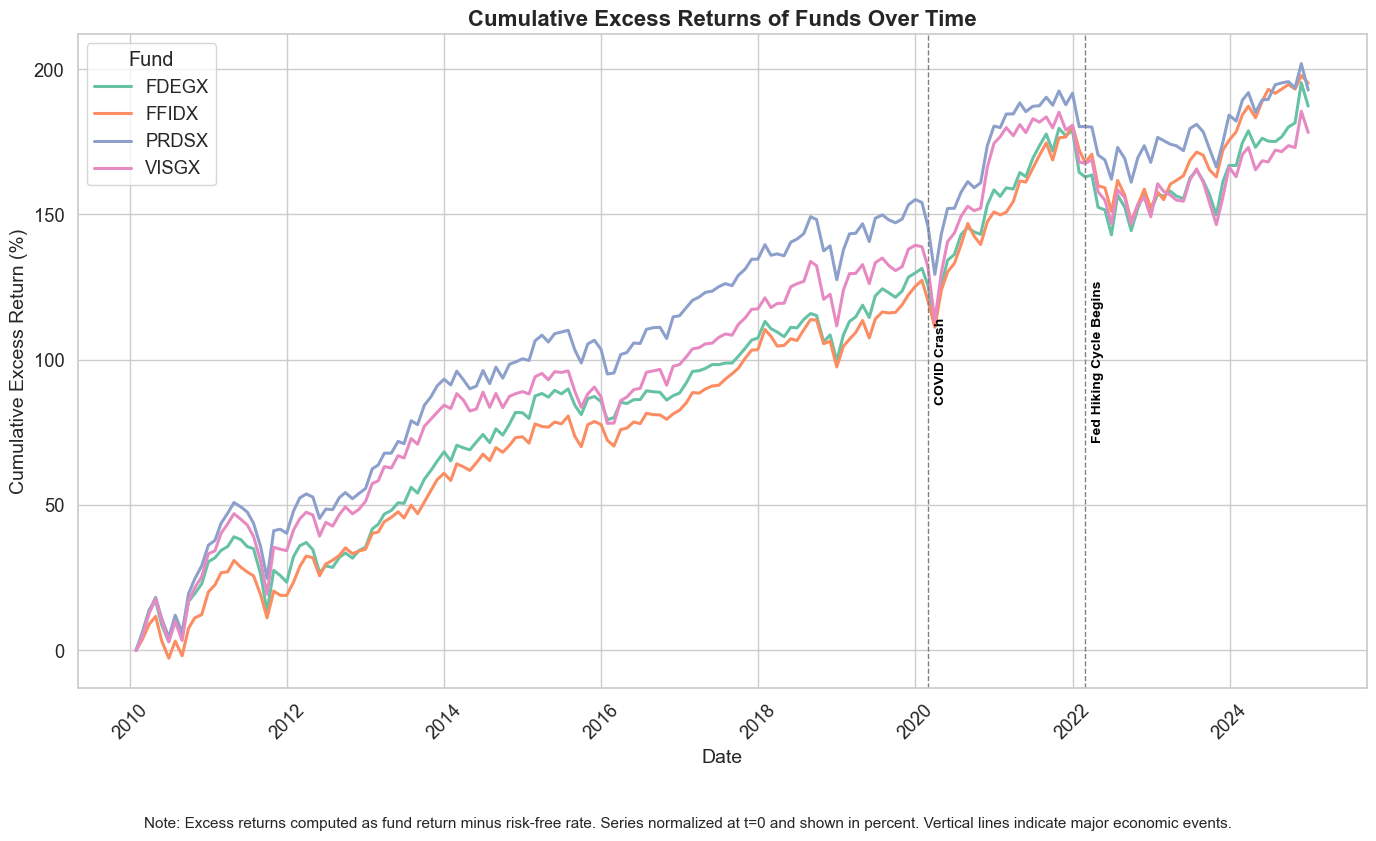

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute excess return per month
merged_df["Excess Return"] = merged_df["Fund Return"] - merged_df["RF"]

# Sort by date for consistency
merged_df.sort_values(by=["Fund Name", "Date"], inplace=True)

# Compute and normalize cumulative excess return
merged_df["Cumulative Excess Return"] = merged_df.groupby("Fund Name")["Excess Return"].cumsum()
merged_df["Cumulative Excess Return"] = merged_df.groupby("Fund Name")["Cumulative Excess Return"].transform(lambda x: x - x.iloc[0])

# Convert to percentage format
merged_df["Cumulative Excess Return %"] = merged_df["Cumulative Excess Return"] * 100

# Setup the plot
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", font_scale=1.2)

# Plot each fund
funds = merged_df["Fund Name"].unique()
palette = sns.color_palette("Set2", len(funds))

for i, fund in enumerate(funds):
    fund_data = merged_df[merged_df["Fund Name"] == fund]
    plt.plot(fund_data["Date"], fund_data["Cumulative Excess Return %"],
             label=fund, linewidth=2.2, color=palette[i])

# Annotate events with vertical lines + labels with spacing
annotate_events = {
    "COVID Crash": "2020-03-01",
    "Fed Hiking Cycle Begins": "2022-03-01"
}

# Set y-limits before placing labels
y_min, y_max = plt.ylim()

for label, date_str in annotate_events.items():
    x_pos = pd.to_datetime(date_str)
    plt.axvline(x_pos, color='grey', linestyle='--', linewidth=1)
    
    # Position label in the vertical middle and slightly to the right of the line
    text_x = x_pos + pd.Timedelta(days=30)  # horizontal offset
    text_y = (y_max + y_min) / 2            # vertical center
    
    plt.text(text_x, text_y, label,
             rotation=90, verticalalignment='center',
             fontsize=10, fontweight='bold', color='black')

# Labels and legend
plt.title("Cumulative Excess Returns of Funds Over Time", fontsize=16, weight='bold')
plt.ylabel("Cumulative Excess Return (%)", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.legend(title="Fund", loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()

# Caption
plt.figtext(0.5, -0.05,
            "Note: Excess returns computed as fund return minus risk-free rate. Series normalized at t=0 and shown in percent. Vertical lines indicate major economic events.",
            wrap=True, horizontalalignment='center', fontsize=11)

plt.show()


# 📘 Q4 - Magnificent Seven Portfolio Evaluation

This section evaluates a value-weighted portfolio of the **Magnificent Seven** stocks:
Apple (AAPL), Microsoft (MSFT), Alphabet (GOOGL), Amazon (AMZN), NVIDIA (NVDA), Meta Platforms (META), and Tesla (TSLA).

### Key Objectives:
- Construct a value-weighted portfolio
- Compute Sharpe ratios and compare with NASDAQ
- Run Fama-French 5-Factor regressions with **Newey-West standard errors**
- Perform analysis at daily, weekly, and monthly frequency
- Compare results with the mutual funds evaluated in **Question 3**


## 🧰 Step 1: Import Libraries

In [19]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

## 📂 Step 2: Load and Prepare Data

In [20]:
# === Load Data === #
stock_data = pd.read_csv("stock_data.csv")
nasdaq_data = pd.read_csv("nasdaq_data.csv")
fama_french_data = pd.read_csv("fama_french_data.csv")

# === Date Format Conversion === #
stock_data['date'] = pd.to_datetime(stock_data['date'], format='%d-%m-%Y')
nasdaq_data['date'] = pd.to_datetime(nasdaq_data['date'])
fama_french_data['date'] = pd.to_datetime(fama_french_data['date'])

# === Ticker Cleanup === #
stock_data['ticker'] = stock_data['ticker'].replace({
    'GOOGL': 'Alphabet', 'GOOG': 'Alphabet',
    'FB': 'Meta', 'META': 'Meta'
})

# === Market Cap and Weights === #
stock_data['market_cap'] = stock_data['prc'] * stock_data['shrout']
stock_data['ret'] = pd.to_numeric(stock_data['ret'], errors='coerce')

# Avoid future pandas warnings
stock_data = stock_data.groupby('date', group_keys=False).apply(
    lambda x: x.assign(weight=x['market_cap'] / x['market_cap'].sum())
)

stock_data['weighted_return'] = stock_data['weight'] * stock_data['ret']
portfolio_returns = stock_data.groupby('date')['weighted_return'].sum().reset_index()
portfolio_returns.rename(columns={'weighted_return': 'portfolio_return'}, inplace=True)

# === Merge with Fama-French Data === #
fama_french_data = fama_french_data.rename(columns={'rf': 'rf_ff'})
portfolio = pd.merge(portfolio_returns, fama_french_data[['date', 'rf_ff']], on='date', how='left')
portfolio['excess_return'] = portfolio['portfolio_return'] - portfolio['rf_ff']

## 📊 Step 3: Daily Sharpe Ratio and FF5 Regression

In [21]:
# === Sharpe Ratios === #
sharpe_portfolio = portfolio['excess_return'].mean() / portfolio['excess_return'].std()

nasdaq_data = pd.merge(nasdaq_data, fama_french_data[['date', 'rf_ff']], on='date', how='left')
nasdaq_data['excess_return'] = nasdaq_data['nasdaq_ret'] - nasdaq_data['rf_ff']
sharpe_nasdaq = nasdaq_data['excess_return'].mean() / nasdaq_data['excess_return'].std()

print(f"Portfolio Sharpe Ratio: {sharpe_portfolio:.4f}")
print(f"NASDAQ Sharpe Ratio: {sharpe_nasdaq:.4f}")

# === Fama-French 5-Factor Regression (Daily) with Newey-West === #
ff_data = pd.merge(portfolio_returns, fama_french_data, on='date')
ff_data['excess_return'] = ff_data['portfolio_return'] - ff_data['rf_ff']

X = add_constant(ff_data[['mktrf', 'smb', 'hml', 'rmw', 'cma']])
y = ff_data['excess_return']
model = OLS(y, X).fit()
nw_results = model.get_robustcov_results(cov_type='HAC', use_correction=True, maxlags=20)

print("\nDaily Fama-French 5-Factor Regression (Newey-West Adjusted):")
print(nw_results.summary())

Portfolio Sharpe Ratio: 0.0785
NASDAQ Sharpe Ratio: 0.0397

Daily Fama-French 5-Factor Regression (Newey-West Adjusted):
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     776.2
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:33:55   Log-Likelihood:                 11887.
No. Observations:                3270   AIC:                        -2.376e+04
Df Residuals:                    3264   BIC:                        -2.372e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------

## 📉 Step 4: Weekly Sharpe Ratio and FF5 Regression

In [22]:
# === Weekly Frequency === #
portfolio['week'] = portfolio['date'] - pd.to_timedelta(portfolio['date'].dt.dayofweek, unit='d')
portfolio_weekly = portfolio.groupby('week')['portfolio_return'].mean().reset_index()

nasdaq_data['week'] = nasdaq_data['date'] - pd.to_timedelta(nasdaq_data['date'].dt.dayofweek, unit='d')
nasdaq_weekly = nasdaq_data.groupby('week')['nasdaq_ret'].mean().reset_index()

fama_french_data['week'] = fama_french_data['date'] - pd.to_timedelta(fama_french_data['date'].dt.dayofweek, unit='d')
ff_weekly = fama_french_data.groupby('week').mean(numeric_only=True).reset_index()

merged_weekly = portfolio_weekly.merge(nasdaq_weekly, on='week') \
    .merge(ff_weekly, on='week') \
    .rename(columns={'week': 'date'})

merged_weekly['portfolio_excess'] = merged_weekly['portfolio_return'] - merged_weekly['rf_ff']
merged_weekly['nasdaq_excess'] = merged_weekly['nasdaq_ret'] - merged_weekly['rf_ff']

sharpe_weekly = merged_weekly['portfolio_excess'].mean() / merged_weekly['portfolio_excess'].std()
sharpe_nasdaq_weekly = merged_weekly['nasdaq_excess'].mean() / merged_weekly['nasdaq_excess'].std()

print(f"Weekly Portfolio Sharpe Ratio: {sharpe_weekly:.4f}")
print(f"Weekly NASDAQ Sharpe Ratio: {sharpe_nasdaq_weekly:.4f}")

# === Weekly Regression with Newey-West === #
Xw = add_constant(merged_weekly[['mktrf', 'smb', 'hml', 'rmw', 'cma']])
yw = merged_weekly['portfolio_excess']
model_weekly = OLS(yw, Xw).fit()
nw_weekly = model_weekly.get_robustcov_results(cov_type='HAC', use_correction=True, maxlags=5)

print("\nWeekly Fama-French 5-Factor Regression (Newey-West Adjusted):")
print(nw_weekly.summary())

Weekly Portfolio Sharpe Ratio: 0.1902
Weekly NASDAQ Sharpe Ratio: 0.0934

Weekly Fama-French 5-Factor Regression (Newey-West Adjusted):
                            OLS Regression Results                            
Dep. Variable:       portfolio_excess   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     250.8
Date:                Thu, 03 Apr 2025   Prob (F-statistic):          4.55e-151
Time:                        10:33:55   Log-Likelihood:                 3012.4
No. Observations:                 679   AIC:                            -6013.
Df Residuals:                     673   BIC:                            -5986.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.

## 📆 Step 5: Monthly Sharpe Ratio and FF5 Regression

In [23]:
# === Monthly Frequency === #
portfolio['month'] = portfolio['date'].dt.to_period('M').dt.to_timestamp()
portfolio_monthly = portfolio.groupby('month')['portfolio_return'].mean().reset_index()

nasdaq_data['month'] = nasdaq_data['date'].dt.to_period('M').dt.to_timestamp()
nasdaq_monthly = nasdaq_data.groupby('month')['nasdaq_ret'].mean().reset_index()

fama_french_data['month'] = fama_french_data['date'].dt.to_period('M').dt.to_timestamp()
ff_monthly = fama_french_data.groupby('month').mean(numeric_only=True).reset_index()

merged_monthly = portfolio_monthly.merge(nasdaq_monthly, on='month') \
    .merge(ff_monthly, on='month') \
    .rename(columns={'month': 'date'})

merged_monthly['portfolio_excess'] = merged_monthly['portfolio_return'] - merged_monthly['rf_ff']
merged_monthly['nasdaq_excess'] = merged_monthly['nasdaq_ret'] - merged_monthly['rf_ff']

sharpe_monthly = merged_monthly['portfolio_excess'].mean() / merged_monthly['portfolio_excess'].std()
sharpe_nasdaq_monthly = merged_monthly['nasdaq_excess'].mean() / merged_monthly['nasdaq_excess'].std()

print(f"Monthly Portfolio Sharpe Ratio: {sharpe_monthly:.4f}")
print(f"Monthly NASDAQ Sharpe Ratio: {sharpe_nasdaq_monthly:.4f}")

# === Monthly Regression with Newey-West === #
Xm = add_constant(merged_monthly[['mktrf', 'smb', 'hml', 'rmw', 'cma']])
ym = merged_monthly['portfolio_excess']
model_monthly = OLS(ym, Xm).fit()
nw_monthly = model_monthly.get_robustcov_results(cov_type='HAC', use_correction=True, maxlags=3)

print("\nMonthly Fama-French 5-Factor Regression (Newey-West Adjusted):")
print(nw_monthly.summary())

Monthly Portfolio Sharpe Ratio: 0.4197
Monthly NASDAQ Sharpe Ratio: 0.2118

Monthly Fama-French 5-Factor Regression (Newey-West Adjusted):
                            OLS Regression Results                            
Dep. Variable:       portfolio_excess   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     115.0
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.73e-49
Time:                        10:33:55   Log-Likelihood:                 817.46
No. Observations:                 156   AIC:                            -1623.
Df Residuals:                     150   BIC:                            -1605.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025     

## 🧮 Does the Magnificent Seven Outperform the Funds?

In [24]:
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# --- Add 'Month' columns to align dates --- #
q3_funds = final_df.copy()
q3_funds['Month'] = q3_funds['Date'].dt.to_period('M').dt.to_timestamp()
nasdaq_monthly = nasdaq_monthly.rename(columns={"month": "Date"})
nasdaq_monthly['Month'] = nasdaq_monthly['Date'].dt.to_period('M').dt.to_timestamp()

# --- Sortino Ratio for Q3 Funds --- #
q3_funds['Downside Return'] = q3_funds['Excess Return'].apply(lambda x: x if x < 0 else 0)

sortino_ratios = q3_funds.groupby("Fund Name").agg(
    mean_return=("Excess Return", "mean"),
    downside_std=("Downside Return", lambda x: np.std(x, ddof=1))
)
sortino_ratios["Sortino Ratio"] = sortino_ratios["mean_return"] / sortino_ratios["downside_std"]
sortino_ratios = sortino_ratios[["Sortino Ratio"]]

# --- Information Ratio for Q3 Funds (vs NASDAQ) --- #
q3_info_ratios = []

for fund in q3_funds["Fund Name"].unique():
    fund_data = q3_funds[q3_funds["Fund Name"] == fund]
    merged = pd.merge(fund_data, nasdaq_monthly, on="Month", how="inner")
    merged["active_return"] = merged["Fund Return"] - merged["nasdaq_ret"]
    mean_active = merged["active_return"].mean()
    std_active = merged["active_return"].std()
    info_ratio = mean_active / std_active
    q3_info_ratios.append([fund, info_ratio])

info_df = pd.DataFrame(q3_info_ratios, columns=["Fund", "Information Ratio"])

# --- Merge Q3 Summary Metrics --- #
q3_summary = results_df[["Fund", "Alpha", "R-Squared"]].copy()
q3_summary = q3_summary.merge(sharpe_ratios[["Fund Name", "Sharpe Ratio"]], left_on="Fund", right_on="Fund Name").drop(columns="Fund Name")
q3_summary = q3_summary.merge(sortino_ratios, left_on="Fund", right_index=True)
q3_summary = q3_summary.merge(info_df, on="Fund")

# --- Metrics for M7 Portfolio (Monthly) --- #
merged_monthly['Month'] = merged_monthly['date'].dt.to_period('M').dt.to_timestamp()
m7_downside = merged_monthly['portfolio_excess'].apply(lambda x: x if x < 0 else 0)
m7_sortino = merged_monthly['portfolio_excess'].mean() / m7_downside.std(ddof=1)
merged_monthly['active_return'] = merged_monthly['portfolio_return'] - merged_monthly['nasdaq_ret']
m7_info_ratio = merged_monthly['active_return'].mean() / merged_monthly['active_return'].std()
m7_alpha = model_monthly.params['const']
m7_r2 = model_monthly.rsquared

m7_row = pd.DataFrame([{
    "Fund": "Magnificent 7",
    "Alpha": m7_alpha,
    "R-Squared": m7_r2,
    "Sharpe Ratio": sharpe_monthly,
    "Sortino Ratio": m7_sortino,
    "Information Ratio": m7_info_ratio
}])

# --- Final Combined Table --- #
final_comparison = pd.concat([q3_summary, m7_row], ignore_index=True)
final_comparison = final_comparison.round(4)

# --- Display with Formatting --- #
from IPython.display import display

display(
    final_comparison.style
        .set_properties(**{
            'text-align': 'center',
            'font-family': 'monospace',
            'font-size': '12px'
        })
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('padding', '6px')]}
        ])
        .format({
            'Alpha': '{:.4f}',
            'R-Squared': '{:.4f}',
            'Sharpe Ratio': '{:.4f}',
            'Sortino Ratio': '{:.4f}',
            'Information Ratio': '{:.4f}',
        }, na_rep='–')
        .set_caption("📊 Comparison Table: Risk-Adjusted Performance of M7 Portfolio vs 4 Funds")
)


,Fund,Alpha,R-Squared,Sharpe Ratio,Sortino Ratio,Information Ratio
0,FFIDX,-0.0005,0.9653,0.2450,0.4384,0.2991
1,FDEGX,-0.0008,0.9020,0.2020,0.3587,0.2434
2,PRDSX,0.0000,0.9449,0.2000,0.3577,0.2186
3,VISGX,-0.0007,0.9668,0.1740,0.3088,0.1906
4,Magnificent 7,0.0005,0.7908,0.4197,0.8888,0.4235


## 🎗️ Visualising the Performance Comparision

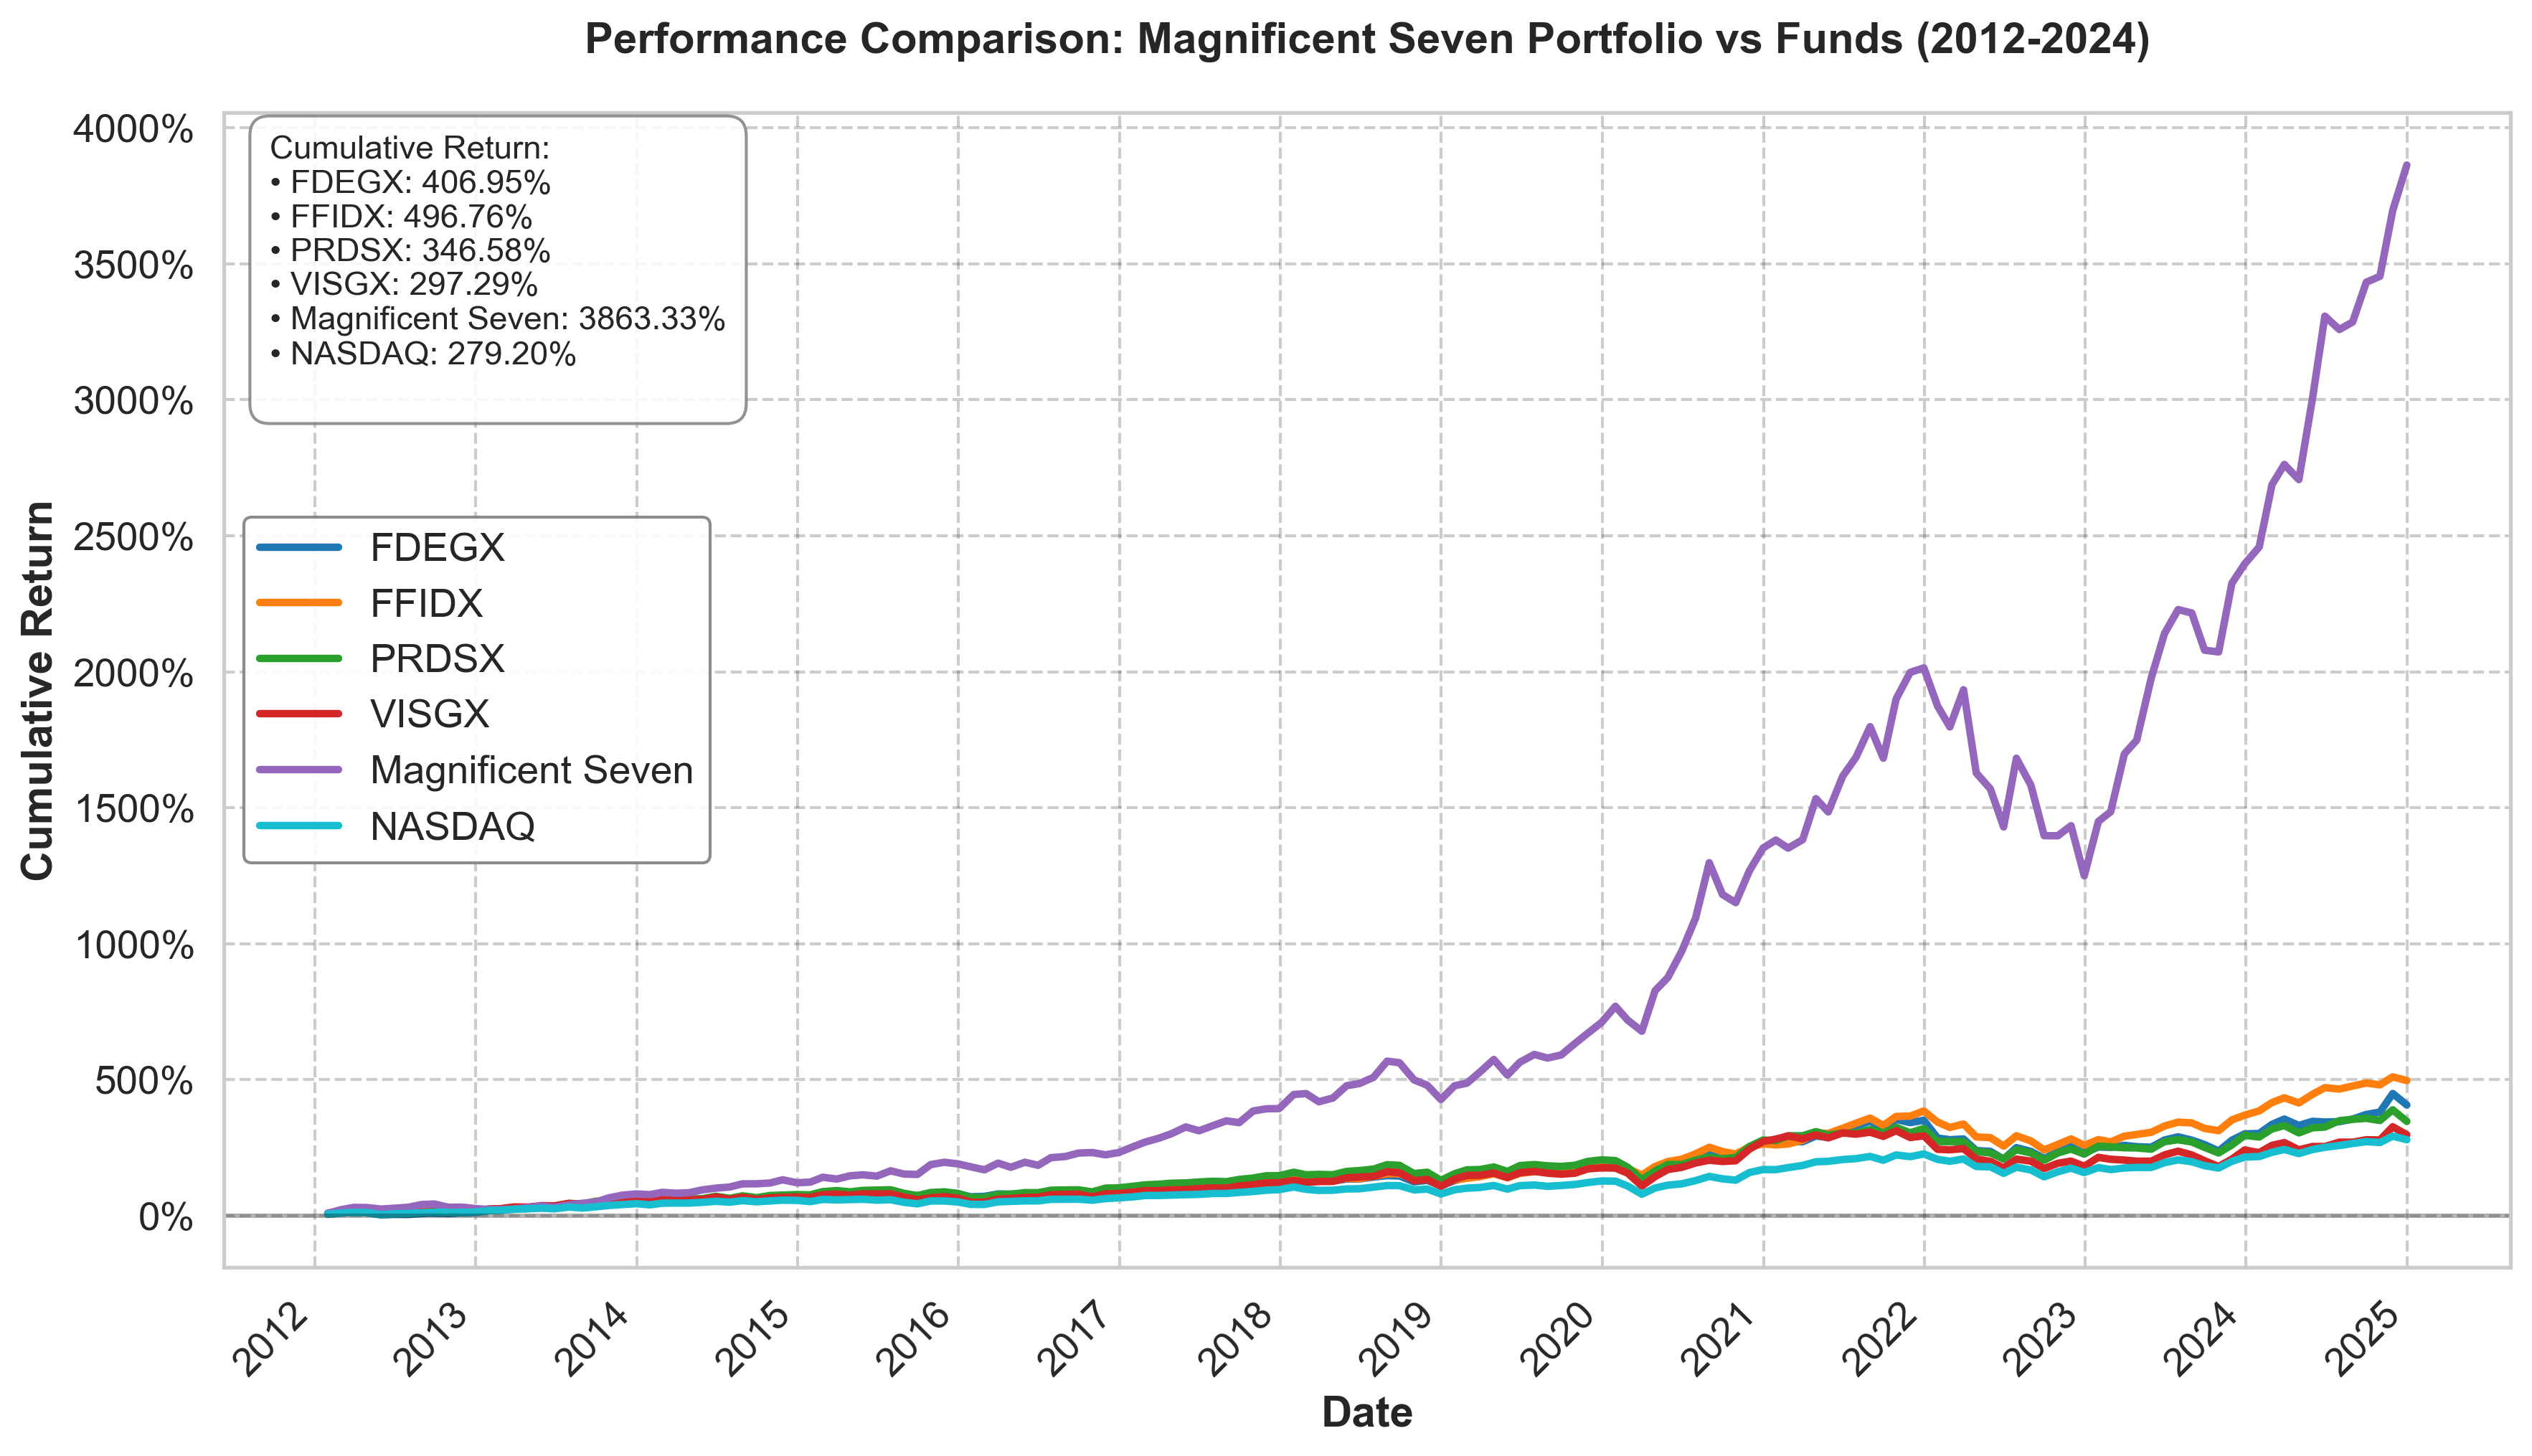

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# 1. Prepare cumulative returns for funds (Q3)
# Assuming funds_df has columns "Date", "Fund Name", "Fund Return"
pivot_funds = funds_df.pivot(index='Date', columns='Fund Name', values='Fund Return')

# Filter from 2012 onwards as mentioned
pivot_funds = pivot_funds.loc['2012-01-01':]

# Calculate cumulative returns for funds (1 + r)
cum_returns_funds = (1 + pivot_funds).cumprod() - 1

# 2. Prepare cumulative returns for Magnificent Seven portfolio (Q4)
# Extract the portfolio returns and align with the same date range
portfolio_returns_aligned = portfolio_returns.set_index('date')
portfolio_returns_aligned = portfolio_returns_aligned.loc['2012-01-01':]

# Calculate cumulative returns for the portfolio
cum_returns_portfolio = (1 + portfolio_returns_aligned['portfolio_return']).cumprod() - 1
cum_returns_portfolio = cum_returns_portfolio.rename('Magnificent Seven')

# 3. Add NASDAQ if available
if 'nasdaq_data' in locals():
    nasdaq_returns_aligned = nasdaq_data.set_index('date')
    nasdaq_returns_aligned = nasdaq_returns_aligned.loc['2012-01-01':]
    cum_returns_nasdaq = (1 + nasdaq_returns_aligned['nasdaq_ret']).cumprod() - 1
    cum_returns_nasdaq = cum_returns_nasdaq.rename('NASDAQ')
    
    # Merge funds, Magnificent Seven, and NASDAQ
    plot_data = cum_returns_funds.join([cum_returns_portfolio, cum_returns_nasdaq], how='inner')
else:
    # Merge just funds and Magnificent Seven
    plot_data = cum_returns_funds.join(cum_returns_portfolio, how='inner')

# 4. Plotting with the preferred style
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
fig, ax = plt.subplots(figsize=(12, 7), dpi=300)

# Plot all series
plot_data.plot(ax=ax, color=colors, linewidth=2.5)

# Configure plot appearance
ax.set_title('Performance Comparison: Magnificent Seven Portfolio vs Funds (2012-2024)', 
             fontweight='bold', pad=20)
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Cumulative Return', fontweight='bold')

# Format axes
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add grid and legend (black grid lines)
ax.grid(True, linestyle='--', color='black', alpha=0.2)
ax.legend(loc='best', frameon=True, framealpha=0.9, edgecolor='gray')

# Add the summary text box with final returns
end_returns = plot_data.iloc[-1]
stats_text = 'Cumulative Return:\n'
for col in plot_data.columns:
    stats_text += f"• {col}: {end_returns[col]:.2%}\n"

ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.85, edgecolor='gray'))

# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Finalize and save
plt.tight_layout()
plt.savefig('cumulative_returns_comparison.png', dpi=300, bbox_inches='tight')
plt.show()